## Credit Fraud Detector

### 1. Introduction
This is a project I found on Kaggle to analyze whether anonymised credit card transations should be labelled as fraudulent or genuine. I undertook this project to get some experience in working with imbalanced datasets, applying the correct methodology to UnderSample / OverSample the dataset. I was working for a Fintech company aiming to build a credit scoring model.  For the Credit Scoring model, there are many more non-defaulting loans than defaulting loans. Similarly in this project, there are many more non-fraudulent transactions than fraudulent transactions.

Kaggle Link: https://www.kaggle.com/mlg-ulb/creditcardfraud

#### Context (from Kaggle description)
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content (from Kaggle description)
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

#### References:
- Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn by Coding-Maniac

#### Importing Modules and Reading Dataset

In [1]:
# General Libraries
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Reading in the dataset
modelling_df = pd.read_csv('C:/Users/briai/Documents/Jupyter/Python Projects/Credit Fraud Detector/creditcard.csv')
modelling_df.head()

Using TensorFlow backend.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Understanding Our Data:
As mentioned earlier, all features except for "time" and "amount" have already been scaled. Therefore we don't know anything about features V1 to V28 except for the fact that they have already been scaled. There are no null values and as expected, the majority of transactions are Non-Fraud, occuring 99.83% of the time and the remaining 0.17% are Fraudulent transactions.

In [2]:
modelling_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
# Checking for any null values
print(modelling_df.isnull().sum().max(), 'null values')

0 null values


In [4]:
# Putting a figure on the level of skew in the target variable
print('No Frauds', round(modelling_df['Class'].value_counts()[0]/len(modelling_df) * 100,2), '% of the dataset')
print('Frauds', round(modelling_df['Class'].value_counts()[1]/len(modelling_df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

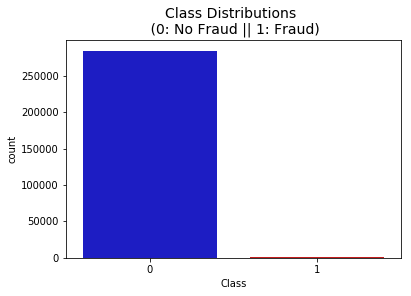

In [5]:
# Creating a chart to show the distribution in the target class
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=modelling_df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

**Note:** The source dataset is very imbalanced. This is a problem since we might get a lot of errors if we use this dataset as the base for our predictive models. This issue arises because our algorithm is likely to overfit because it will learn to "assume" that the majpority of transactions are non fraudulent.

### 3. Preprocessing our Data
First of all, we need to scale the columns "Time" and "Amount" just as the other columns are scaled. 

#### Sub-Sampling
To solve the imbalanced data problem, we create a sub-sample of the dataset that has an equal number of Fraud and Non-Fraud cases. Our algorithm will therefore be better able to understand the underlying indicators as to whether a transaction is Fraud or not. We will set up our sub-samples to have a 50/50 ratio of Fraud and Non-Fraud cases. 

As mentioned, the original dataframe was highly imbalanced in favour of Non-Fraud cases. Using the original dataframe would cause several issues:
- Overfitting: The model is will overfit the data and effectively assume that there are no frauds in the majority of cases.  
- Incorrect Correlations: To evaluate the correlations between the input features and the target feature (Fraud vs Non-Fraud), we need to have an equal distribution in the target variable. 

In [6]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()
# Fitting the robust scaler to the "amount" and "time" variables
modelling_df['scaled_amount'] = rob_scaler.fit_transform(modelling_df['Amount'].values.reshape(-1,1))
modelling_df['scaled_time'] = rob_scaler.fit_transform(modelling_df['Time'].values.reshape(-1,1))

modelling_df.drop(['Time','Amount'], axis=1, inplace=True)
scaled_amount = modelling_df['scaled_amount']
scaled_time = modelling_df['scaled_time']
modelling_df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
modelling_df.insert(0, 'scaled_amount', scaled_amount)
modelling_df.insert(1, 'scaled_time', scaled_time)

modelling_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


#### Splitting the Data (Original DataFrame)
To implement the Random UnderSampling technique, we must first divide the original dataframe into a training set and a testing set. We do this so that we can test the model on the **original testing set**, as opposed to a testing set created using Random UnderSampling 

Here we want to fit the model using the manipulated dataframe (UnderSampled or OverSampled) and proceed to test the model on the original testing set.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = modelling_df.drop('Class', axis=1)
y = modelling_df['Class']

# Creating 3 folds with stratified classes in the target variable
sss = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Combining training datasets and testing datasets
original_train = np.c_[original_Xtrain, original_ytrain]
original_test = np.c_[original_Xtest, original_ytest]

Train: [ 63421  63634  64329 ... 284804 284805 284806] Test: [    0     1     2 ... 94986 94987 94988]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 63421  63634  64329 ... 189912 189913 189914]
Train: [     0      1      2 ... 189912 189913 189914] Test: [152223 152295 153823 ... 284804 284805 284806]


#### Checking Size and Shape of Data

In [8]:
print("Size of Training set: " , round(original_Xtrain.shape[0] / (original_Xtrain.shape[0] + original_Xtest.shape[0])*100, 2), "%")
print("Size of Test set: ", round(original_Xtest.shape[0] / (original_Xtrain.shape[0] + original_Xtest.shape[0])*100, 2), "%")

print('--' * 45)

print('Default Training set -', round(len(original_ytrain[original_ytrain == 1]) / len(original_ytrain)*100, 2), "%")
print('Default Test set -', round(len(original_ytest[original_ytest == 1]) / len(original_ytest)*100, 2), "%")

Size of Training set:  66.67 %
Size of Test set:  33.33 %
------------------------------------------------------------------------------------------
Default Training set - 0.17 %
Default Test set - 0.17 %


### 4. Random Under-Sampling and Oversampling:
The goal of these techniques are to produce a dataset that has an even distribution in the target variable. The former consists of removing data to achieve a balanced dataset and the latter consists of creating new synthetic data points to increase the frequency of the minority class. 

#### Implementing Random UnderSampling during Cross Validation:
There is a common mistake made when carrying out these UnderSampling and OverSampling techniques. It is important not to undersample or oversample a dataset before cross-validating. The reason behind this is that we would be directly altering the validation set in advance of implementing cross-validation which would cause a "data-leakage" problem. Hence we conduct Random UnderSampling / SMOTE duirng the cross-validation process and not beforehand. Otherwise the results will be overfitting. 

#### Summary:
- We carry out UnderSampling during Cross Validation and not beforehand 
- KNN and Logistic Regression have the best accuracy scores while SVC and Decision Trees have poor accuracy scores. 

In [21]:
# Creating empty lists for each evaluation metric and for each model type
undersample_accuracy_logreg = []
undersample_precision_logreg = []
undersample_recall_logreg = []
undersample_f1_logreg = []
undersample_auc_logreg = []
undersample_accuracy_knn = []
undersample_precision_knn = []
undersample_recall_knn = []
undersample_f1_knn = []
undersample_auc_knn = []
undersample_accuracy_svc = []
undersample_precision_svc = []
undersample_recall_svc = []
undersample_f1_svc = []
undersample_auc_svc = []
undersample_accuracy_trees = []
undersample_precision_trees = []
undersample_recall_trees = []
undersample_f1_trees = []
undersample_auc_trees = []

# Instantiating the parameters to be Grid Searched by each model
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
knn_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree']}
svc_params = {'C': [0.5, 0.7, 0.9, 1.0], 'kernel': ['rbf','sigmoid']}  
tree_params = {"criterion": ["gini", "entropy"], 
               "max_depth": list(range(2,6,1)),
               "min_samples_leaf": list(range(1,7,1))}

# Setting up the Grid Search Cross Validation
rand_logreg = GridSearchCV(LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000), log_reg_params, scoring="recall")
rand_knn = GridSearchCV(KNeighborsClassifier(), knn_params, scoring="recall")
rand_svc = GridSearchCV(SVC(), svc_params, scoring="recall")
rand_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, scoring="recall")

# Implementing Random UnderSampling NearMiss Technique (Cross Validating the right way)
for train_index, valid_index in sss.split(original_Xtrain, original_ytrain):

    # Fitting best model for Logistic Regression
    undersample_pipeline_logreg = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), rand_logreg) # Undersampling happens during Cross Validation not before
    undersample_model_logreg = undersample_pipeline_logreg.fit(original_Xtrain[train_index], original_ytrain[train_index])
    undersample_prediction_logreg = undersample_model_logreg.predict(original_Xtrain[valid_index])

    # Fitting best model for KNN
    undersample_pipeline_knn = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), rand_knn) # Undersampling happens during Cross Validation not before
    undersample_model_knn = undersample_pipeline_knn.fit(original_Xtrain[train_index], original_ytrain[train_index])
    undersample_prediction_knn = undersample_model_knn.predict(original_Xtrain[valid_index])

    # Fitting best model for SVC
    undersample_pipeline_svc = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), svc_uds) # Undersampling happens during Cross Validation not before
    undersample_model_svc = undersample_pipeline_svc.fit(original_Xtrain[train_index], original_ytrain[train_index])
    undersample_prediction_svc = undersample_model_svc.predict(original_Xtrain[valid_index])

    # Fitting best model for Trees
    undersample_pipeline_trees = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), tree_clf_uds) # Undersampling happens during Cross Validation not before
    undersample_model_trees = undersample_pipeline_trees.fit(original_Xtrain[train_index], original_ytrain[train_index])
    undersample_prediction_trees = undersample_model_trees.predict(original_Xtrain[valid_index])
          
    #### Calculating Performance Metrics for each Model
    # Performance Metrics for Logreg model
    undersample_accuracy_logreg.append(undersample_pipeline_logreg.score(original_Xtrain[valid_index], original_ytrain[valid_index]))
    undersample_precision_logreg.append(precision_score(original_ytrain[valid_index], undersample_prediction_logreg))
    undersample_recall_logreg.append(recall_score(original_ytrain[valid_index], undersample_prediction_logreg))
    undersample_f1_logreg.append(f1_score(original_ytrain[valid_index], undersample_prediction_logreg))
    undersample_auc_logreg.append(roc_auc_score(original_ytrain[valid_index], undersample_prediction_logreg))
    
    # Performance Metrics for KNN model
    undersample_accuracy_knn.append(undersample_pipeline_knn.score(original_Xtrain[valid_index], original_ytrain[valid_index]))
    undersample_precision_knn.append(precision_score(original_ytrain[valid_index], undersample_prediction_knn))
    undersample_recall_knn.append(recall_score(original_ytrain[valid_index], undersample_prediction_knn))
    undersample_f1_knn.append(f1_score(original_ytrain[valid_index], undersample_prediction_knn))
    undersample_auc_knn.append(roc_auc_score(original_ytrain[valid_index], undersample_prediction_knn))

    # Performance Metrics for SVC model
    undersample_accuracy_svc.append(undersample_pipeline_svc.score(original_Xtrain[valid_index], original_ytrain[valid_index]))
    undersample_precision_svc.append(precision_score(original_ytrain[valid_index], undersample_prediction_svc))
    undersample_recall_svc.append(recall_score(original_ytrain[valid_index], undersample_prediction_svc))
    undersample_f1_svc.append(f1_score(original_ytrain[valid_index], undersample_prediction_svc))
    undersample_auc_svc.append(roc_auc_score(original_ytrain[valid_index], undersample_prediction_svc))

    # Performance Metrics for Trees model
    undersample_accuracy_trees.append(undersample_pipeline_trees.score(original_Xtrain[valid_index], original_ytrain[valid_index]))
    undersample_precision_trees.append(precision_score(original_ytrain[valid_index], undersample_prediction_trees))
    undersample_recall_trees.append(recall_score(original_ytrain[valid_index], undersample_prediction_trees))
    undersample_f1_trees.append(f1_score(original_ytrain[valid_index], undersample_prediction_trees))
    undersample_auc_trees.append(roc_auc_score(original_ytrain[valid_index], undersample_prediction_trees))

print('Logistic Regression')
print('')
print("accuracy: {}".format( round(np.mean(undersample_accuracy_logreg)*100, 2)), "%" )
print("precision: {}".format( round(np.mean(undersample_precision_logreg)*100, 2)), "%" )
print("recall: {}".format( round(np.mean(undersample_recall_logreg)*100, 2)), "%" )
print("f1: {}".format( round(np.mean(undersample_f1_logreg)*100, 2)), "%" )
print("AUC: {}".format( round(np.mean(undersample_auc_logreg)*100, 2)), "%" )
print('--' * 45)
print('KNN')
print('')
print("accuracy: {}".format( round(np.mean(undersample_accuracy_knn)*100, 2)), "%" )
print("precision: {}".format( round(np.mean(undersample_precision_knn)*100, 2)), "%" )
print("recall: {}".format( round(np.mean(undersample_recall_knn)*100, 2)), "%" )
print("f1: {}".format( round(np.mean(undersample_f1_knn)*100, 2)), "%" )
print("AUC: {}".format( round(np.mean(undersample_auc_knn)*100, 2)), "%" )
print('--' * 45)
print('SVC')
print('')
print("accuracy: {}".format( round(np.mean(undersample_accuracy_svc)*100, 2)), "%" )
print("precision: {}".format( round(np.mean(undersample_precision_svc)*100, 2)), "%" )
print("recall: {}".format( round(np.mean(undersample_recall_svc)*100, 2)), "%" )
print("f1: {}".format( round(np.mean(undersample_f1_svc)*100, 2)), "%" )
print("AUC: {}".format( round(np.mean(undersample_auc_svc)*100, 2)), "%" )
print('--' * 45)
print('Trees')
print('')
print("accuracy: {}".format( round(np.mean(undersample_accuracy_trees)*100, 2)), "%" )
print("precision: {}".format( round(np.mean(undersample_precision_trees)*100, 2)), "%" )
print("recall: {}".format( round(np.mean(undersample_recall_trees)*100, 2)), "%" )
print("f1: {}".format( round(np.mean(undersample_f1_trees)*100, 2)), "%" )
print("AUC: {}".format( round(np.mean(undersample_auc_trees)*100, 2)), "%" )
print('--' * 45)

Logistic Regression

accuracy: 95.41 %
precision: 0.34 %
recall: 95.41 %
f1: 0.69 %
AUC: 73.0 %
------------------------------------------------------------------------------------------
KNN

accuracy: 92.68 %
precision: 0.41 %
recall: 92.68 %
f1: 0.81 %
AUC: 73.92 %
------------------------------------------------------------------------------------------
SVC

accuracy: 11.45 %
precision: 0.19 %
recall: 96.94 %
f1: 0.38 %
AUC: 54.12 %
------------------------------------------------------------------------------------------
Trees

accuracy: 13.54 %
precision: 0.18 %
recall: 91.75 %
f1: 0.37 %
AUC: 52.58 %
------------------------------------------------------------------------------------------


### 4. SMOTE Analysis

Now we will carry out a similar procedure known as SMOTE (Synthetic Minority Over-sampling Technique). This is different to Random UnderSampling in that it creates new synthetic data points to ensure there is an equal balance between the two classes in the target variable.

#### Oversampling during cross validation

Similar to the problem we encountered before, we need to carry out the OverSampling method during Cross Validation as opposed to beforehand. We do this to avoid the "Data Leakage" problem descrived earlier in this notebok.

In [22]:
# Creating empty lists for each evaluation metric and for each model type
oversample_accuracy_logreg = []
oversample_precision_logreg = []
oversample_recall_logreg = []
oversample_f1_logreg = []
oversample_auc_logreg = []
oversample_accuracy_knn = []
oversample_precision_knn = []
oversample_recall_knn = []
oversample_f1_knn = []
oversample_auc_knn = []

# Instantiating the parameters to be Grid Searched by each model
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
knn_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree']}

# Setting up the Grid Search Cross Validation
rand_logreg = GridSearchCV(LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000), log_reg_params, scoring="recall")
rand_knn = GridSearchCV(KNeighborsClassifier(), knn_params, scoring="recall")

# Implementing OverSampling SMOTE Technique (Cross Validating the right way)
for train_index, valid_index in sss.split(original_Xtrain, original_ytrain):
    
    #### Fitting each Model
    # Fitting best model for Logistic Regression
    oversample_pipeline_logreg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_logreg) # SMOTE happens during Cross Validation not before
    oversample_model_logreg = oversample_pipeline_logreg.fit(original_Xtrain[train_index], original_ytrain[train_index]) 
    oversample_prediction_logreg = oversample_model_logreg.predict(original_Xtrain[valid_index])
    
    # Fitting best model for KNN
    oversample_pipeline_knn = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_knn) # SMOTE happens during Cross Validation not before
    oversample_model_knn = oversample_pipeline_knn.fit(original_Xtrain[train_index], original_ytrain[train_index]) 
    oversample_prediction_knn = oversample_model_knn.predict(original_Xtrain[valid_index])
    
    #### Calculating Performance Metrics for each Model
    # Performance Metrics for Logreg model
    oversample_accuracy_logreg.append(oversample_pipeline_logreg.score(original_Xtrain[valid_index], original_ytrain[valid_index]))
    oversample_precision_logreg.append(precision_score(original_ytrain[valid_index], oversample_prediction_logreg))
    oversample_recall_logreg.append(recall_score(original_ytrain[valid_index], oversample_prediction_logreg))
    oversample_f1_logreg.append(f1_score(original_ytrain[valid_index], oversample_prediction_logreg))
    oversample_auc_logreg.append(roc_auc_score(original_ytrain[valid_index], oversample_prediction_logreg))

    # Performance Metrics for KNN model
    oversample_accuracy_knn.append(oversample_pipeline_knn.score(original_Xtrain[valid_index], original_ytrain[valid_index]))
    oversample_precision_knn.append(precision_score(original_ytrain[valid_index], oversample_prediction_knn))
    oversample_recall_knn.append(recall_score(original_ytrain[valid_index], oversample_prediction_knn))
    oversample_f1_knn.append(f1_score(original_ytrain[valid_index], oversample_prediction_knn))
    oversample_auc_knn.append(roc_auc_score(original_ytrain[valid_index], oversample_prediction_knn))
    
print('Logistic Regression')
print('')
print("accuracy: {}".format( round(np.mean(oversample_accuracy_logreg)*100, 2)), "%" )
print("precision: {}".format( round(np.mean(oversample_precision_logreg)*100, 2)), "%" )
print("recall: {}".format( round(np.mean(oversample_recall_logreg)*100, 2)), "%" )
print("f1: {}".format( round(np.mean(oversample_f1_logreg)*100, 2)), "%" )
print("AUC: {}".format( round(np.mean(oversample_auc_logreg)*100, 2)), "%" )
print('--' * 45)
print('KNN')
print('')
print("accuracy: {}".format( round(np.mean(oversample_accuracy_knn)*100, 2)), "%" )
print("precision: {}".format( round(np.mean(oversample_precision_knn)*100, 2)), "%" )
print("recall: {}".format( round(np.mean(oversample_recall_knn)*100, 2)), "%" )
print("f1: {}".format( round(np.mean(oversample_f1_knn)*100, 2)), "%" )
print("AUC: {}".format( round(np.mean(oversample_auc_knn)*100, 2)), "%" )
print('--' * 45)

Logistic Regression

accuracy: 87.18 %
precision: 4.95 %
recall: 87.18 %
f1: 9.12 %
AUC: 86.13 %
------------------------------------------------------------------------------------------
KNN

accuracy: 73.78 %
precision: 46.67 %
recall: 73.78 %
f1: 55.79 %
AUC: 86.8 %
------------------------------------------------------------------------------------------


---

### 5. Test Data with Logistic Regression:
Now we apply our classification models to the test dataset created earlier in the analysis. 

#### Summary:
- Classification Models: The models that performed the best were logistic regression and KNN so we apply these to the test data.
- We apply the models that were trained the "right" way (OverSampling / UnderSampling during CV) and the  "wrong" way (OverSampling / UnderSampling before CV).
- The models that were trained the "right" way perform much better when faced with the unseen test dataset

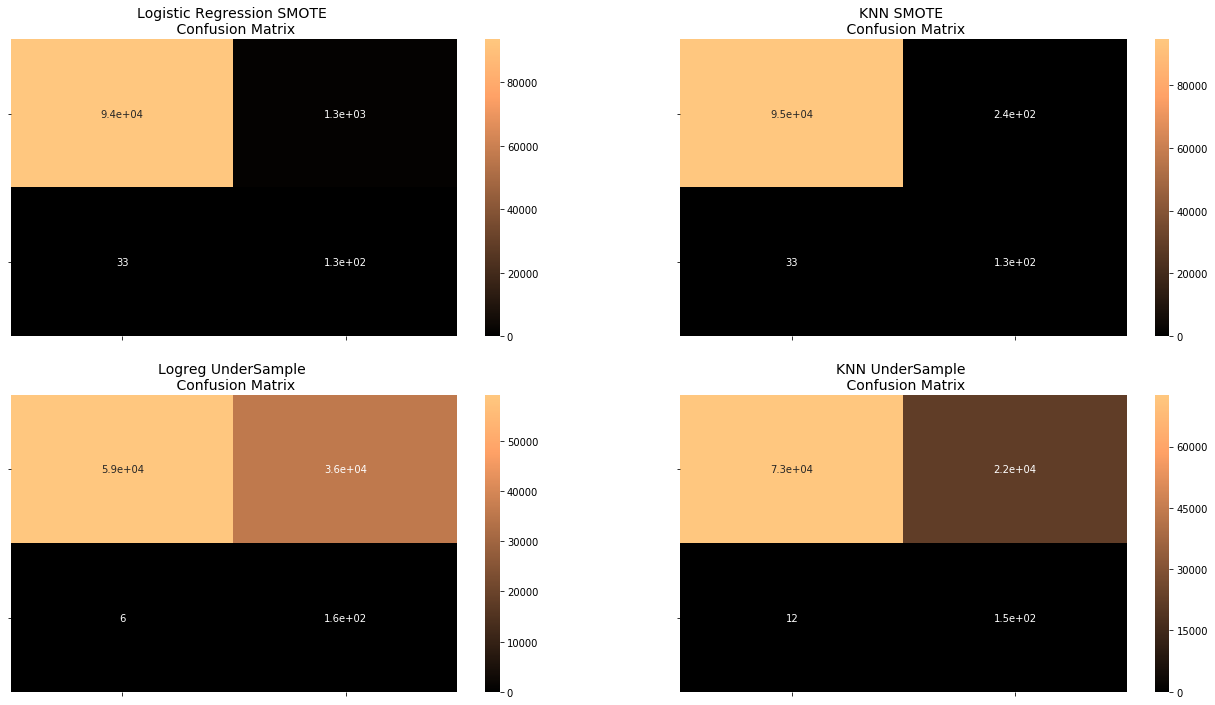

In [23]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_logreg_sm = oversample_model_logreg.predict(original_Xtest)
# KNN fitted using SMOTE technique
y_pred_knn_sm = oversample_model_knn.predict(original_Xtest)

# Other models fitted with UnderSampling
y_pred_logreg_uds = undersample_model_logreg.predict(original_Xtest)
y_pred_knn_uds = undersample_model_knn.predict(original_Xtest)

logreg_sm_cf = confusion_matrix(original_ytest, y_pred_logreg_sm)
knn_sm_cf = confusion_matrix(original_ytest, y_pred_knn_sm)
logreg_uds_cf = confusion_matrix(original_ytest, y_pred_logreg_uds)
knn_uds_cf = confusion_matrix(original_ytest, y_pred_knn_uds)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(logreg_sm_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression SMOTE \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(knn_sm_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNN SMOTE \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(logreg_uds_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Logreg UnderSample \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(knn_uds_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("KNN UnderSample \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [24]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(original_ytest, y_pred_logreg_sm))

print('KNears Neighbors:')
print(classification_report(original_ytest, y_pred_knn_sm))

print('Support Vector Classifier:')
print(classification_report(original_ytest, y_pred_logreg_uds))

print('Support Vector Classifier:')
print(classification_report(original_ytest, y_pred_knn_uds))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     94771
           1       0.09      0.80      0.17       164

    accuracy                           0.99     94935
   macro avg       0.55      0.89      0.58     94935
weighted avg       1.00      0.99      0.99     94935

KNears Neighbors:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94771
           1       0.36      0.80      0.49       164

    accuracy                           1.00     94935
   macro avg       0.68      0.90      0.75     94935
weighted avg       1.00      1.00      1.00     94935

Support Vector Classifier:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77     94771
           1       0.00      0.96      0.01       164

    accuracy                           0.62     94935
   macro avg       0.50      0.79      0.39     94935
weighted

In [27]:
# Final Score in the test set of Logistic Regression and KNN

# Logistic Regression with Under-Sampling
y_pred_logreg_uds = undersample_model_logreg.predict(original_Xtest)
undersample_score_logreg = accuracy_score(original_ytest, y_pred_logreg_uds)
# Logistic Regression with SMOTE Technique 
y_pred_logreg_sm = oversample_model_logreg.predict(original_Xtest)
oversample_score_logreg = accuracy_score(original_ytest, y_pred_logreg_sm)

# KNN with Under-Sampling
y_pred_knn_uds = undersample_model_knn.predict(original_Xtest)
undersample_score_knn = accuracy_score(original_ytest, y_pred_knn_uds)
# KNN with SMOTE Technique 
y_pred_knn_sm = oversample_model_knn.predict(original_Xtest)
oversample_score_knn = accuracy_score(original_ytest, y_pred_knn_sm)

# Creating the results dataframe
results_data = {'Technique': ['Logreg: UnderSampling', 'Logreg - OverSampling', 'KNN - UnderSampling', 'KNN - OverSampling'], 
                'Score': [undersample_score_logreg, oversample_score_logreg, undersample_score_knn, oversample_score_knn]}
results_df = pd.DataFrame(data=results_data)

score = results_df['Score']
results_df.drop('Score', axis=1, inplace=True)
results_df.insert(1, 'Score', score)

results_df

,Technique,Score
0,Logreg: UnderSampling,0.623427
1,Logreg - OverSampling,0.986317
2,KNN - UnderSampling,0.765713
3,KNN - OverSampling,0.997177


---

### Conclusion:
In this notebook we have implemented Random UnderSampling and SMOTE OverSampling with the correct Cross Validation methodology. By manipulating the datasets **during** cross validation and not beforehand, we avoid a Data Leakage problem and ensure the models are trained correctly.

---